In [14]:
from models.model import UNET
import numpy as np
from torch import nn
import torch
import torch.nn.functional as F
import imageio
from tqdm import tqdm
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from matplotlib import pyplot as plt

In [126]:
model = UNET.load_from_checkpoint("../models/checkpoints/epoch=2-step=21664.ckpt")
model.eval()

UNET(
  (encoder): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

In [127]:
from src.data.dataset import BCSSDataset
data = BCSSDataset("../data/processed", "train")
train_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

In [128]:
image, mask = next(iter(train_loader))
temp = torch.zeros(mask.shape[2:])
for i in range(6):
    temp[torch.where(mask[0, i].to(int).to(bool))] = i
mask = temp.reshape(1, 512, 512)

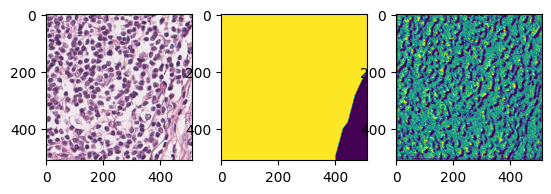

In [130]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(torch.moveaxis(image[0], 0, 2))
ax[1].imshow(torch.moveaxis(mask, 0, 2))
ax[2].imshow(torch.moveaxis(model(image).argmax(1), 0, 2))
plt.show()